In [21]:
import tensorflow as tf
import numpy as np

# Define the dataset
X = np.array([
    [1, 1],
    [1, 2],
    [1, 3],
    [2, 1],
    [2, 2],
    [4, 4],
    [4, 5],
    [4, 6],
    [5, 4],
    [5, 5],
    [5, 6]
])

# Labels (0 or 1)
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

# Define the perceptron model using the Sequential API
model = tf.keras.Sequential()

# Add a Dense layer with one neuron (perceptron), input_dim=2 (for two features)
model.add(tf.keras.layers.Dense(1, input_dim=2, activation='sigmoid'))

# Compile the model with binary crossentropy loss for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Custom callback to extract weights after each epoch
class WeightsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.layers[0].get_weights()[0]
        bias = self.model.layers[0].get_weights()[1]
        print(f"\nEpoch {epoch + 1}:")
        print(f"Weights:\n{weights}")
        print(f"Bias:\n{bias}")
        print(f"Loss: {logs}")



c:\Users\nandi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
weights = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]
print(f"\nEpoch 0:")
print(f"Weights:\n{weights}")
print(f"Bias:\n{bias}")



Epoch 0:
Weights:
[[-0.20891082]
 [-0.06850958]]
Bias:
[0.]


In [23]:
# Train the model and update weights using backpropagation
history = model.fit(X, y, epochs=1, verbose=2, callbacks=[WeightsCallback()])



Epoch 1:
Weights:
[[-0.20791084]
 [-0.06750958]]
Bias:
[0.00099998]
Loss: {'accuracy': 0.4545454680919647, 'loss': 1.0646239519119263}
1/1 - 1s - 585ms/step - accuracy: 0.4545 - loss: 1.0646


In [24]:
weights = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]
print(f"\nEpoch 0:")
print(f"Weights:\n{weights}")
print(f"Bias:\n{bias}")


Epoch 0:
Weights:
[[-0.20791084]
 [-0.06750958]]
Bias:
[0.00099998]


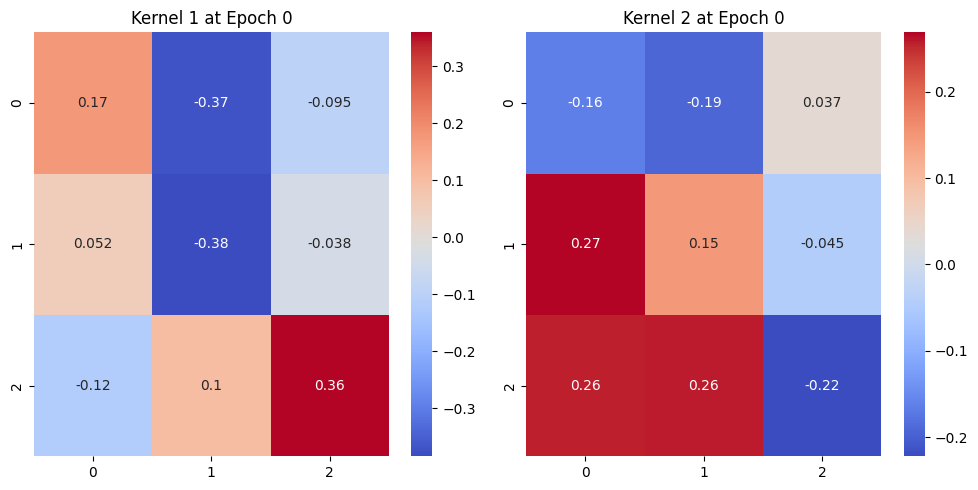

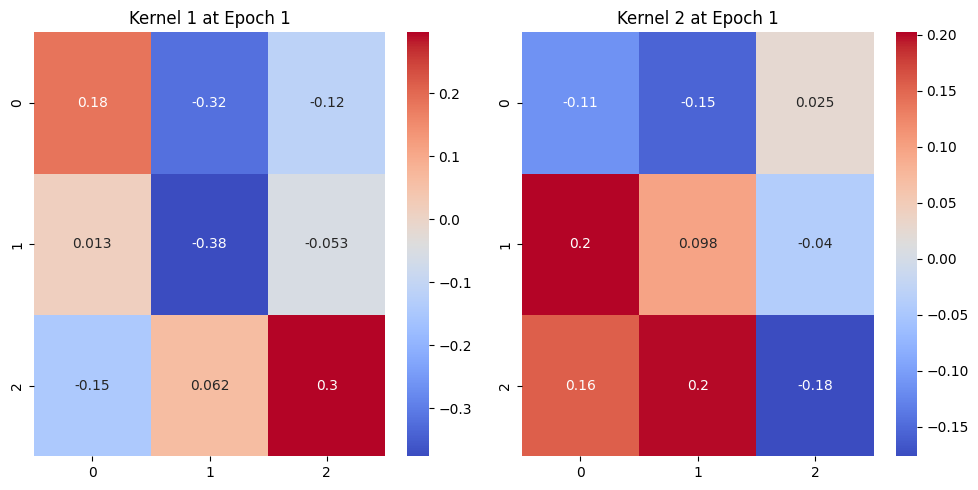

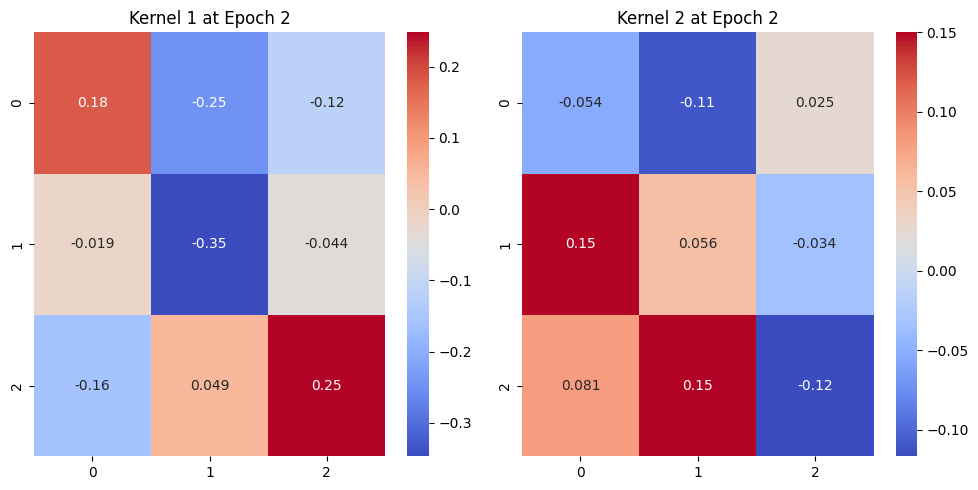

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Example data (kernel weights from different epochs)
kernel_data = {
    0: {
        'Kernel 1': np.array([[ 0.17474148, -0.3699617,  -0.09506125],
                              [ 0.05202647, -0.38383168, -0.03766607],
                              [-0.11797558,  0.09977147,  0.35947016]]),
        'Kernel 2': np.array([[-0.16436733, -0.19186679,  0.03698387],
                              [ 0.26859117,  0.14686191, -0.04507556],
                              [ 0.2561024,   0.2589294,  -0.2218697 ]])
    },
    1: {
        'Kernel 1': np.array([[ 0.18437792, -0.3201166,  -0.11566284],
                              [ 0.01345934, -0.37665257, -0.05300254],
                              [-0.14563827,  0.062259,    0.29720986]]),
        'Kernel 2': np.array([[-0.11273615, -0.15407474,  0.02542173],
                              [ 0.2020514,   0.09784153, -0.03975471],
                              [ 0.15530992,  0.19920798, -0.17616244]])
    },
    2: {
        'Kernel 1': np.array([[ 0.17963322, -0.24823518, -0.11748385],
                              [-0.01868992, -0.346859,   -0.04366028],
                              [-0.15737586,  0.04949743,  0.2480862 ]]),
        'Kernel 2': np.array([[-0.05350496, -0.11107805,  0.02506169],
                              [ 0.15003935,  0.05604785, -0.03360495],
                              [ 0.08106993,  0.1500554,  -0.1167936 ]])
    }
}

# Function to visualize kernel weights as heatmaps
def visualize_kernels(kernel_data):
    for epoch, kernels in kernel_data.items():
        plt.figure(figsize=(10, 5))
        for i, (kernel_name, kernel) in enumerate(kernels.items()):
            plt.subplot(1, 2, i + 1)
            sns.heatmap(kernel, annot=True, cmap='coolwarm', cbar=True)
            plt.title(f'{kernel_name} at Epoch {epoch}')
        plt.tight_layout()
        plt.show()

# Visualize kernel updates
visualize_kernels(kernel_data)
